In [24]:
!pip install pysindy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pysindy as ps
from sklearn.metrics import mean_squared_error, r2_score
import multiprocessing
import concurrent.futures


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# New Section

In [25]:
NUM_TUBES = 3
num_cores = multiprocessing.cpu_count()


def simulate_model(Y_test, U_test, model):
    results = model.simulate(Y_test[0, 0:3], len(Y_test), U_test)
    return results


def main():
    # Make the CSV files into pandas dataframes
    minmax_df = pd.read_csv('./drive/MyDrive/bit_data/calib_results.csv', header=None)
    level_df = pd.read_csv('./drive/MyDrive/bit_data/bit_data_6.csv')
    gain_df = pd.read_csv('./drive/MyDrive/MATLAB/rgs_signals_6.csv')

    # Convert dataframes to numpy arrays
    minmax_array = minmax_df.to_numpy()
    data_array = level_df.to_numpy()[3:, :]
    gain_array = gain_df.to_numpy()[3:, :]

    # Scale the data using MinMaxScaler (0-1)
    gain_scaler = preprocessing.MinMaxScaler()
    height_scaler = preprocessing.MinMaxScaler()
    Y = height_scaler.fit_transform(data_array[:, 4:7])
    gain_scaler.fit_transform(gain_array[:, 0:3])

    # Concatenate minmax values and reshape them
    minmax_vals = np.concatenate((height_scaler.data_min_, height_scaler.data_max_,
                                  gain_scaler.data_min_, gain_scaler.data_max_), axis=0)

    num_elements = int(minmax_vals.size / NUM_TUBES)
    minmax_vals = np.reshape(minmax_vals, (num_elements, NUM_TUBES))

    # Print minmax values
    for i in range(num_elements):
        print(list(minmax_vals[i]))

    # Scale the input data for training and testing
    U = gain_scaler.fit_transform(data_array[:, 0:3])
    train_split = round(0.8 * data_array.shape[0])
    test_split = data_array.shape[0] - train_split
    U_train, U_test = U[0:train_split], U[train_split:]
    Y_train, Y_test = Y[0:train_split], Y[train_split:]

    # Set up SINDy model parameters
    feature_library = ps.PolynomialLibrary(degree=3)
    optimizer = ps.STLSQ(threshold=0.0924)
    diff_method = ps.SmoothedFiniteDifference()
    feature_names = ['x4', 'x3', 'x2', 'u4', 'u3', 'u2']

    # Create and fit the SINDy model
    model = ps.SINDy(discrete_time=True,
                     differentiation_method=diff_method,
                     feature_names=feature_names,
                     feature_library=feature_library,
                     optimizer=optimizer)

    model.fit(x=Y_train, u=U_train, t=0.5, unbias=True)
    model.print()

    # Simulate the model for testing data
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
        results = list(executor.map(simulate_model, [Y_test] * num_cores, [U_test] * num_cores, [model] * num_cores))

    # Plot the predicted vs actual results
    fig, axs = plt.subplots(3, sharex='all', figsize=(12, 7))
    fig.suptitle("Predicted vs Actual Results")

    count = 4

    for i in range(3):
        for result in results:
          axs[i].plot(result[:, i], color='tab:blue', ls='--', label=f'Tube {i + count} predicted')
          axs[i].plot(Y_test[:, i], color='tab:gray', alpha=0.5, label=f'Tube {i + count} actual')
          axs[i].legend(loc='upper left')
          count -= 2

    # Calculate and set MSE and R-squared values in the title
    mse = round(mean_squared_error(Y_test, results[0]), 5)
    rs = round(r2_score(Y_test, results[0]), 5)
    axs[0].title.set_text(f'RSquare: {rs} MSE: {mse}')
    plt.savefig('./bit_data/sindy_model_6.pdf')
    plt.show()


[329.0, 363.0, 354.0]
[13529.0, 15304.0, 14495.0]
[32.0, 16.0, 42.0]
[76.0, 100.0, 82.0]
(x4)[k+1] = 0.312 1 + 0.976 x4[k] + -0.850 u4[k] + -0.341 x4[k]^2 + 0.546 u4[k]^2 + 0.140 x4[k]^3 + 0.512 x4[k]^2 u4[k] + -0.552 x4[k] u4[k]^2 + 0.133 x4[k] u4[k] u3[k]
(x3)[k+1] = 0.802 1 + 0.937 x3[k] + -3.131 u3[k] + 0.048 x4[k] x2[k] + -0.033 x4[k] u3[k] + -0.318 x3[k]^2 + 0.865 x3[k] u3[k] + 0.200 x3[k] u2[k] + -0.043 x2[k] u3[k] + 0.017 u4[k] u3[k] + 3.815 u3[k]^2 + -0.070 u3[k] u2[k] + -0.107 x4[k] x2[k] u3[k] + 0.084 x4[k] u3[k]^2 + -0.707 x3[k]^3 + 2.571 x3[k]^2 u3[k] + -0.190 x3[k]^2 u2[k] + 0.168 x3[k] u4[k] u3[k] + -0.112 x3[k] u4[k] u2[k] + -2.842 x3[k] u3[k]^2 + 0.080 x2[k] u3[k]^2 + -0.234 u4[k]^2 u3[k] + 0.101 u4[k]^2 u2[k] + 0.172 u4[k] u3[k]^2 + -1.496 u3[k]^3 + 0.112 u3[k]^2 u2[k]
(x2)[k+1] = 0.402 1 + 1.088 x2[k] + -0.724 u2[k] + -1.052 x2[k]^2 + 0.072 x2[k] u2[k] + 0.583 x2[k]^3 + 0.793 x2[k]^2 u2[k] + -0.471 x2[k] u2[k]^2 + 0.314 u2[k]^3


FileNotFoundError: ignored

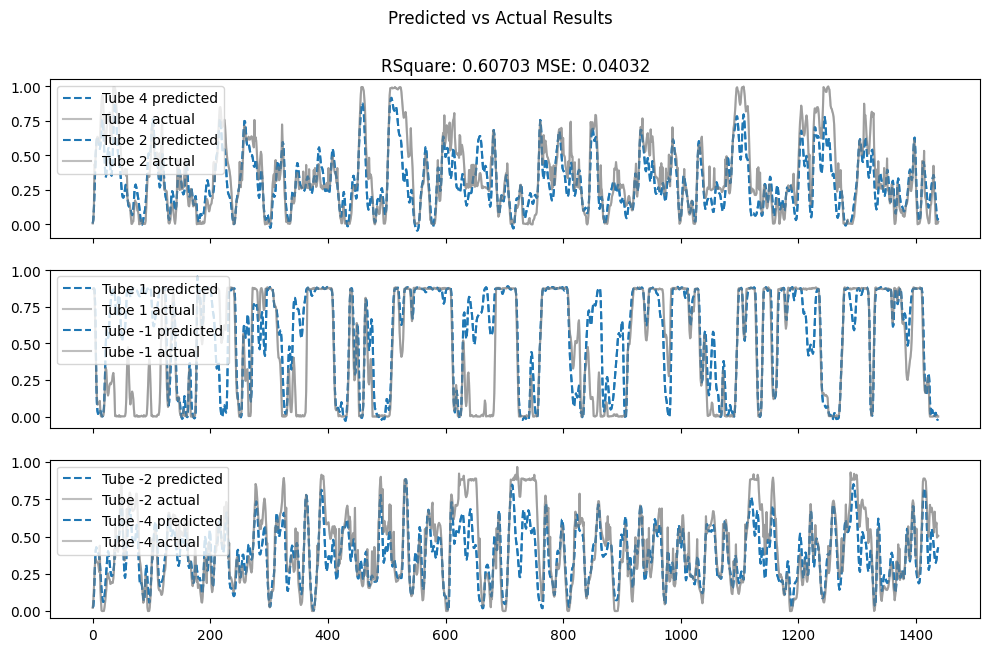

In [26]:
if __name__ == '__main__':
    main()